In [1]:
from utils import *

from os import listdir
from os.path import isfile, join

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(49)

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

In [5]:
dataset_ex_df = pd.read_csv('TSLA.csv', header=0, parse_dates=[0], date_parser=parser)

In [6]:
dataset_ex_df.head()

,Date,TSLA
0,2010-06-30,4.766
1,2010-07-01,4.392
2,2010-07-02,3.840
3,2010-07-06,3.222
4,2010-07-07,3.160


In [7]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2393 number of days in the dataset.


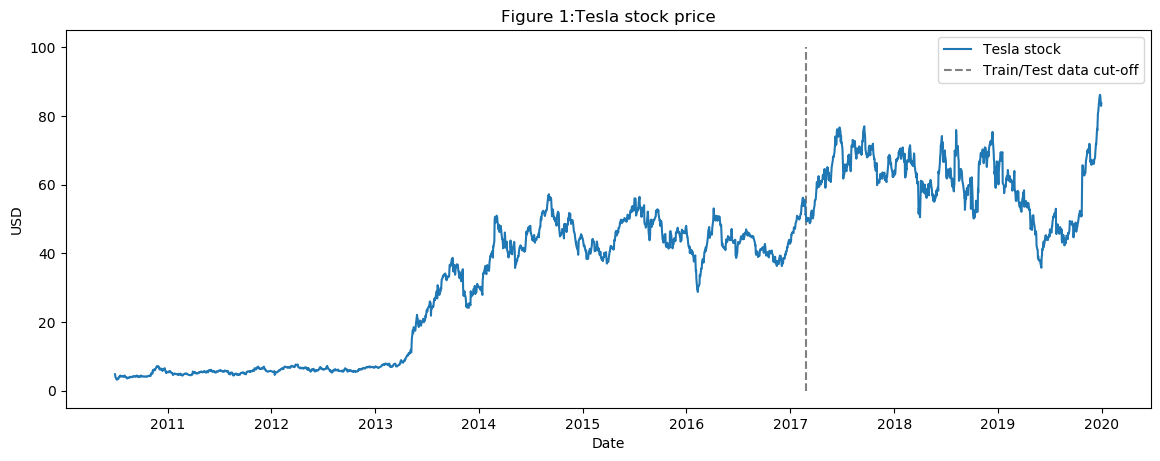

In [8]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='Tesla stock')
plt.vlines(datetime.date(2017,2, 24), 0, 100, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1:Tesla stock price')
plt.legend()
plt.show()

In [9]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1675. Number of test days: 718.


In [10]:
#adding features
for i in ['bonds', 'commodities', 'currencies', 'indices', 'libor', 'stocks']:
    mypath = 'correlated_assets/' + str(i)
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for j in onlyfiles:
        dataset_tmpr = pd.read_csv('correlated_assets/'+str(i)+'/'+str(j), header=0, parse_dates=[0], date_parser=parser)
        dataset_tmpr = dataset_tmpr[(dataset_tmpr['Date'] > '2010-06-29') & (dataset_tmpr['Date'] < '2020-01-01')]
        dataset_tmpr = dataset_tmpr.drop(['Open', 'High', 'Low'], axis = 1).reset_index(drop = True)
        dataset_tmpr.columns = ['Date', j[:-4]]
        dataset_ex_df = dataset_ex_df.merge(dataset_tmpr, how = 'left', on = 'Date')    

In [11]:
dataset_ex_df = dataset_ex_df.fillna(method = 'ffill')
#last resort
dataset_ex_df = dataset_ex_df.fillna(method = 'bfill')

In [12]:
dataset_ex_df.head()

,Date,TSLA,10usy_b_d,30usy_b_d,cb_f_d,cl_f_d,gc_f_d,rb_f_d,usdchf_d,usdeur_d,...,F,FCAU,GM,HMC,HYMTF,NSANY,PUGOY,RNOPA,TM,VOW3DE
0,2010-06-30,4.766,2.951,3.909,74.69,75.24,1242.6,2.0600,1.0777,0.8175,...,10.08,3.226447,34.189999,28.750000,21.250000,13.86,25.65,30.785000,68.570000,72.379997
1,2010-07-01,4.392,2.927,3.868,72.19,72.68,1199.8,1.9910,1.0596,0.7988,...,10.57,3.226447,34.189999,28.799999,19.799999,13.72,25.34,29.559999,68.699997,69.970001
2,2010-07-02,3.840,2.979,3.941,71.63,72.14,1207.7,1.9777,1.0622,0.7959,...,10.28,3.226447,34.189999,28.590000,19.799999,13.76,26.10,30.170000,68.260002,70.070000
3,2010-07-06,3.222,2.932,3.892,71.77,72.02,1194.0,1.9775,1.0595,0.7921,...,10.16,3.226447,34.189999,29.190001,19.799999,14.62,26.10,31.125000,70.029999,71.379997
4,2010-07-07,3.160,2.980,3.954,74.46,74.85,1202.5,2.0425,1.0522,0.7918,...,10.59,3.226447,34.189999,29.459999,19.400000,14.62,28.15,32.145000,71.000000,71.239998


In [13]:
#adding technical indicators
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['TSLA'].rolling(window=7).mean()
    dataset['ma21'] = dataset['TSLA'].rolling(window=21).mean()
    
    #Create MACD
    dataset['26ema'] = pd.Series.ewm(dataset['TSLA'], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset['TSLA'], span=12).mean()
    
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['TSLA'].rolling(window = 20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['TSLA'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['TSLA']-1
    
    return dataset

In [14]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['TSLA']])

In [15]:
dataset_TI_df.head()

,TSLA,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,4.766,NaN,NaN,4.766000,4.766000,0.000000,NaN,NaN,NaN,4.766000,3.766
1,4.392,NaN,NaN,4.571808,4.563417,-0.008391,NaN,NaN,NaN,4.485500,3.392
2,3.840,NaN,NaN,4.308876,4.281067,-0.027809,NaN,NaN,NaN,4.038615,2.840
3,3.222,NaN,NaN,4.005033,3.946761,-0.058272,NaN,NaN,NaN,3.487400,2.222
4,3.160,NaN,NaN,3.809066,3.733001,-0.076066,NaN,NaN,NaN,3.268231,2.160


In [16]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['TSLA'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.15)
    plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

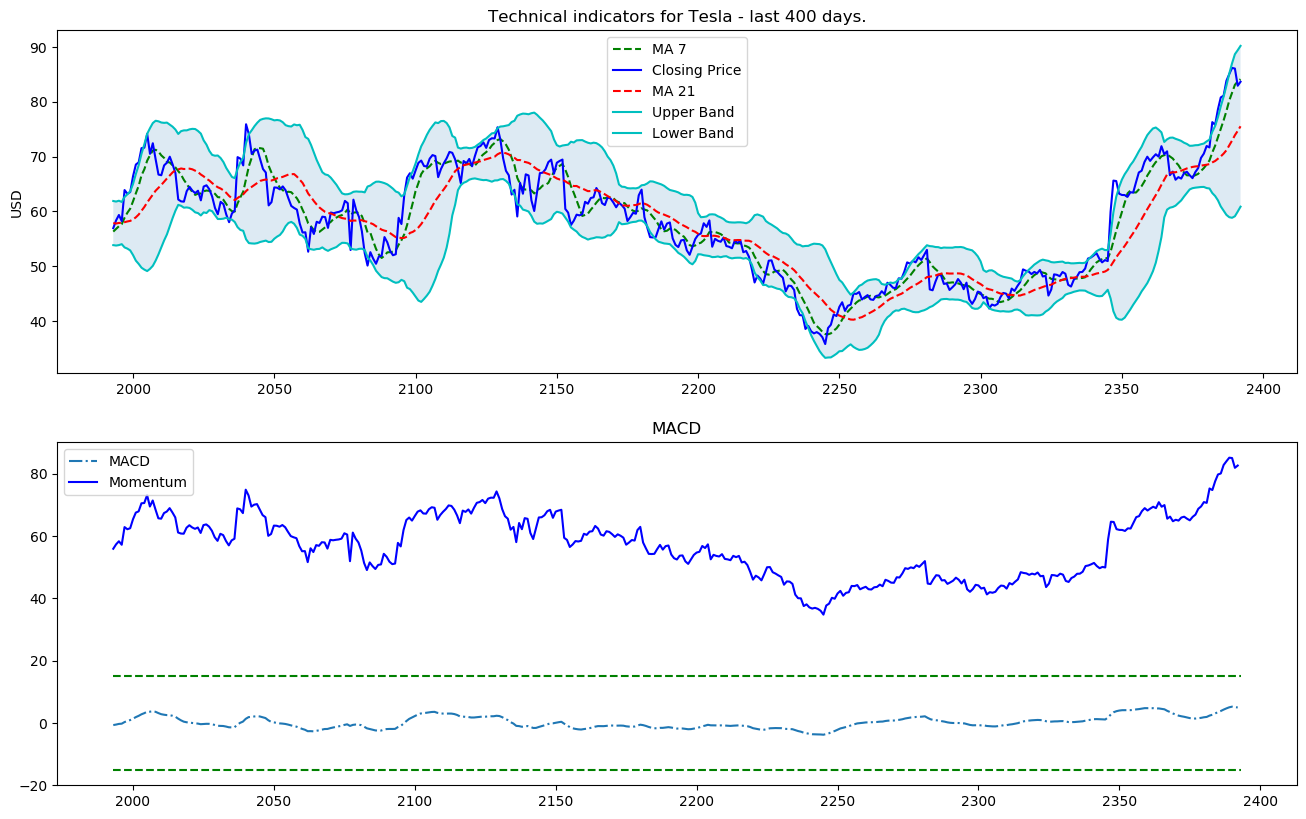

In [17]:
plot_technical_indicators(dataset_TI_df, 400)

In [18]:
data_FT = dataset_ex_df[['Date', 'TSLA']]
data_FT

,Date,TSLA
0,2010-06-30,4.766000
1,2010-07-01,4.392000
2,2010-07-02,3.840000
3,2010-07-06,3.222000
4,2010-07-07,3.160000
...,...,...
2388,2019-12-24,85.050003
2389,2019-12-26,86.188004
2390,2019-12-27,86.075996
2391,2019-12-30,82.940002


In [19]:
close_fft = np.fft.fft(np.asarray(data_FT['TSLA'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

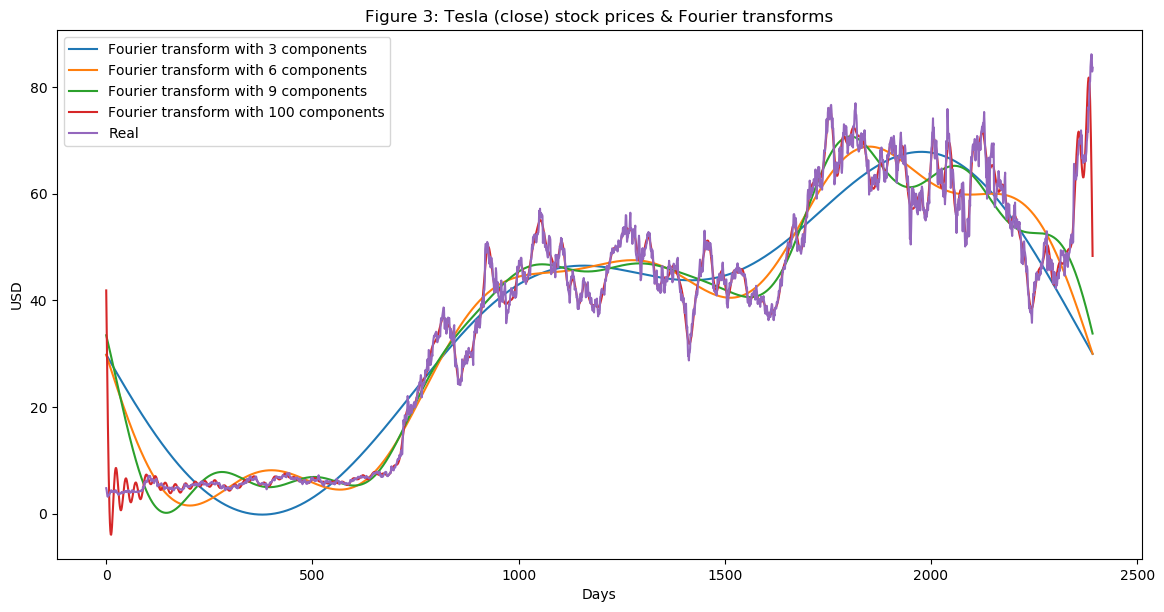

In [20]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    data_FT['fourier_'+str(num_)] = np.fft.ifft(fft_list_m10)
plt.plot(data_FT['TSLA'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Tesla (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

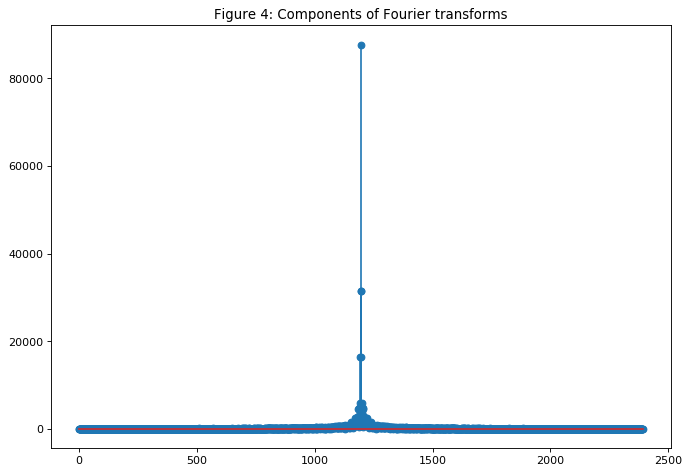

In [21]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['TSLA']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TSLA   No. Observations:                 2392
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3932.094
Method:                       css-mle   S.D. of innovations              1.252
Date:                Wed, 16 Sep 2020   AIC                           7878.188
Time:                        17:39:57   BIC                           7918.647
Sample:                             1   HQIC                          7892.909
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0330      0.024      1.351      0.177      -0.015       0.081
ar.L1.D.TSLA    -0.0062      0.020     -0.305      0.761      -0.046       0.034
ar.L2.D.TSLA     0.0137      0.020      0.67

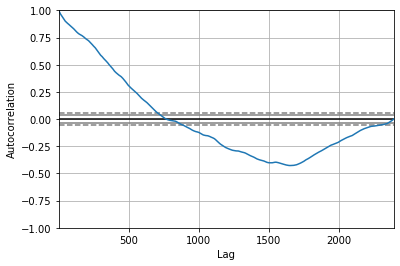

<Figure size 800x560 with 0 Axes>

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [24]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [25]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 3.151


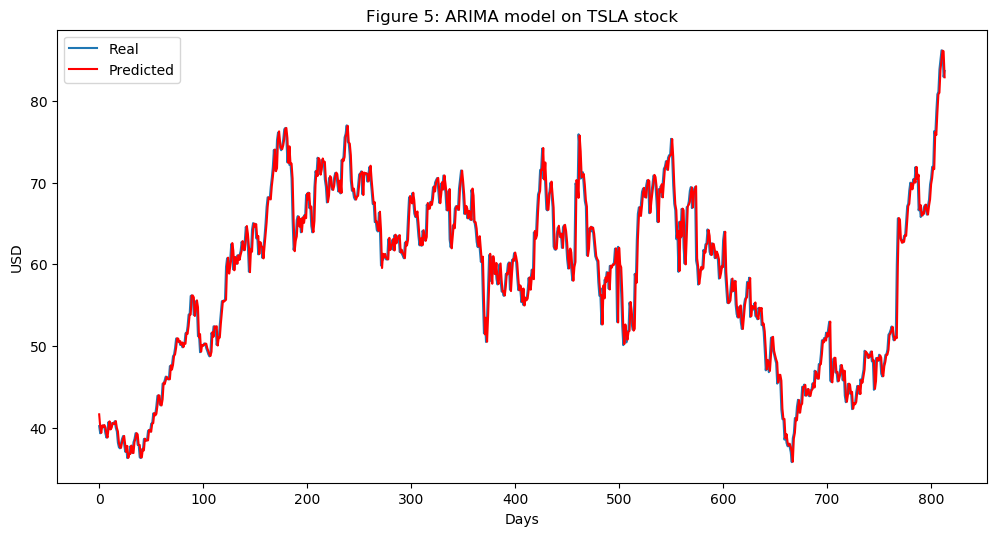

In [26]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on TSLA stock')
plt.legend()
plt.show()

In [27]:
dataset_TI_df['Date'] = data_FT['Date']

In [28]:
dataset_total_df = dataset_ex_df.merge(dataset_TI_df, how = 'left', on = 'Date')  
dataset_total_df = dataset_total_df.merge(data_FT, how = 'left', on = 'Date')  
dataset_total_df = dataset_total_df.drop(['TSLA_x', 'TSLA_y'] , axis = 1)

In [29]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 2393 samples, and 53 features.


In [30]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['TSLA']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [31]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df.drop(['Date'], axis = 1))

In [32]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [33]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [34]:
eval_result = regressor.evals_result()

In [35]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

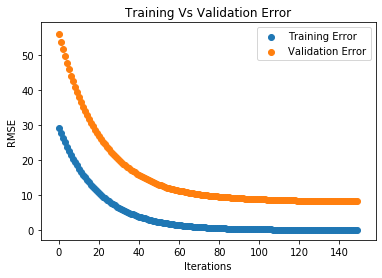

In [36]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

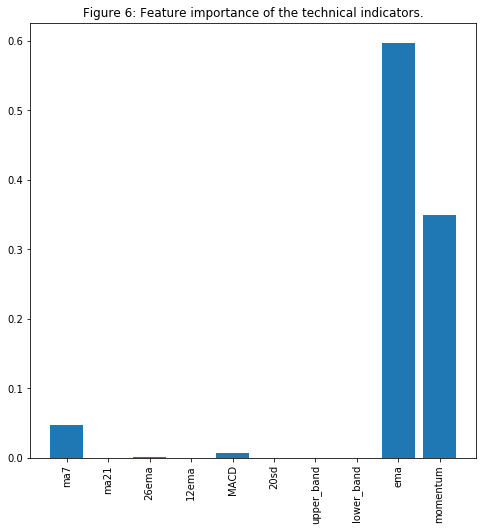

In [37]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [38]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

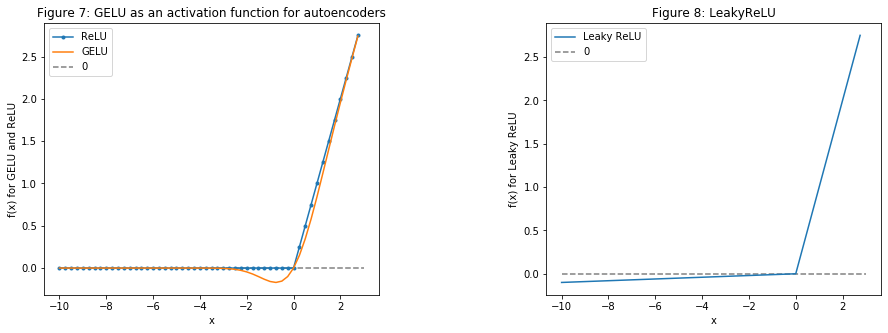

In [39]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [40]:
VAE_data = dataset_total_df.drop('Date', axis = 1)

batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [41]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [42]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='relu')

In [43]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [44]:
print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 51, Activation(sigmoid))
  )
)


In [45]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Training completed in 116 seconds.


In [46]:
dataset_total_df['fourier_3'] = dataset_total_df['fourier_3'].apply(np.real)
dataset_total_df['fourier_6'] = dataset_total_df['fourier_6'].apply(np.real)
dataset_total_df['fourier_9'] = dataset_total_df['fourier_9'].apply(np.real)
dataset_total_df['fourier_100'] = dataset_total_df['fourier_100'].apply(np.real)
dataset_total_df['Date'] = dataset_ex_df['Date']

In [49]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, 1:].values)

In [50]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

The shape of the newly created (from the autoencoder) features is (2393, 52).
